In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision import datasets
import matplotlib.pyplot as plt
from skimage import color
from skimage.metrics import structural_similarity as ssim
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np
from tqdm import tqdm

KeyboardInterrupt: 

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)

In [ ]:
import os
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.classes, self.class_to_idx = self._find_classes(self.data_dir)
        self.samples = self._make_dataset(self.data_dir)

    def _find_classes(self, dir):
        classes = [d.name for d in os.scandir(dir) if d.is_dir()]
        classes.sort()
        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        return classes, class_to_idx

    def _make_dataset(self, dir):
        images = []
        for target_class in self.classes:
            class_dir = os.path.join(dir, target_class)
            for root, _, fnames in sorted(os.walk(class_dir)):
                for fname in sorted(fnames):
                    path = os.path.join(root, fname)
                    item = (path, self.class_to_idx[target_class])
                    images.append(item)
        return images

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, target = self.samples[idx]
        sample = Image.open(path).convert('RGB')
        if self.transform is not None:
            sample = self.transform(sample)
        return sample, target

In [13]:
from skimage import io, color
import skimage.color as skcolor
import torch
from torch.utils.data import DataLoader

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Create dataset and dataloader for train data
train_dataset = CustomDataset(data_dir='/content/drive/MyDrive/hymenoptera_data/train', transform=transform)

train_dataset_lab = []
for img, label in train_dataset:  # Unpack the tuple returned by CustomDataset
    lab_img = skcolor.rgb2lab(img.permute(1, 2, 0).numpy())  # Convert to LAB colorspace
    lab_img = torch.from_numpy(lab_img.transpose(2, 0, 1))  # Convert to tensor
    train_dataset_lab.append((lab_img, img))

train_dataloader = DataLoader(train_dataset_lab, batch_size=32, shuffle=True)

# Create dataset and dataloader for validation data
val_dataset = CustomDataset(data_dir='/content/drive/MyDrive/hymenoptera_data/val', transform=transform)

val_dataset_lab = []
for img, label in val_dataset:  # Unpack the tuple returned by CustomDataset
    lab_img = skcolor.rgb2lab(img.permute(1, 2, 0).numpy())  # Convert to LAB colorspace
    lab_img = torch.from_numpy(lab_img.transpose(2, 0, 1))  # Convert to tensor
    val_dataset_lab.append((lab_img, img))

val_dataloader = DataLoader(val_dataset_lab, batch_size=32, shuffle=False)


In [14]:
class CAE(nn.Module):
    def __init__(self):
        super(CAE, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(256, 512, 3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(inplace=True),
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1),
            nn.BatchNorm2d(3),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [15]:
# import torchvision.datasets as datasets

# # Define transformations
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
# ])

# # Create dataset and dataloader for train data
# train_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/hymenoptera_data/train', transform=transform)
# train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# # Create dataset and dataloader for validation data
# val_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/hymenoptera_data/val', transform=transform)
# val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [16]:

# Initialize model, loss function, and optimizer
model = CAE()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.to(device)

CAE(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01, inplace=True)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01, inplace=True)
    (9): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.01, inplace=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), strid

In [17]:
def train(model, criterion, optimizer, train_loader, val_loader, num_epochs=10):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for batch_idx, (data,target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            recon_batch = model(data)
            loss = criterion(recon_batch, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * data.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                recon_batch = model(data)
                val_loss += criterion(recon_batch, target).item() * data.size(0)

        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {epoch_loss:.4f}, '
              f'Val Loss: {val_loss:.4f}')

    return train_losses, val_losses

# Train the model
train_losses, val_losses = train(model, criterion, optimizer, train_dataloader, val_dataloader, num_epochs=10)


Epoch [1/10], Train Loss: 0.1942, Val Loss: 0.2470
Epoch [2/10], Train Loss: 0.0917, Val Loss: 0.1055
Epoch [3/10], Train Loss: 0.0804, Val Loss: 0.0966
Epoch [4/10], Train Loss: 0.0734, Val Loss: 0.0864
Epoch [5/10], Train Loss: 0.0677, Val Loss: 0.0757
Epoch [6/10], Train Loss: 0.0619, Val Loss: 0.0684
Epoch [7/10], Train Loss: 0.0588, Val Loss: 0.0607
Epoch [8/10], Train Loss: 0.0561, Val Loss: 0.0574
Epoch [9/10], Train Loss: 0.0551, Val Loss: 0.0537
Epoch [10/10], Train Loss: 0.0534, Val Loss: 0.0513


<ipython-input-22-50cd92d14ae0>:30: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(original, reconstructed, multichannel=True)


Average MSE: 0.0513
Average RMSE: 0.2263
Average SSIM: 0.0013
Average PSNR: -31.33


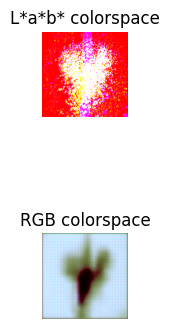

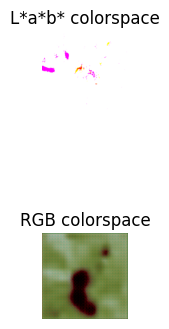

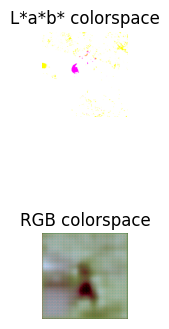

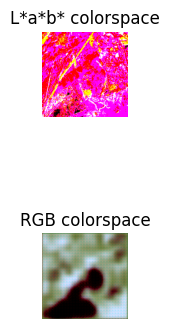

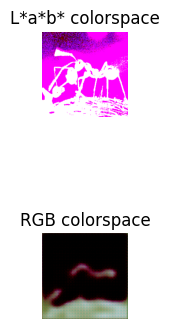

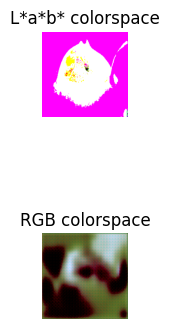

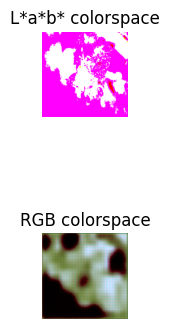

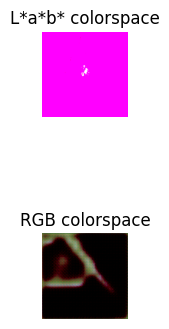

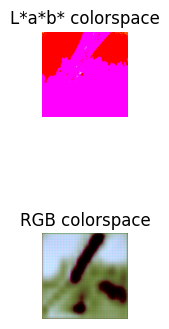

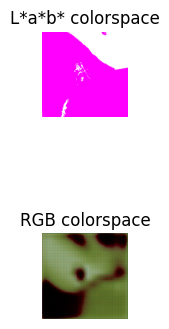

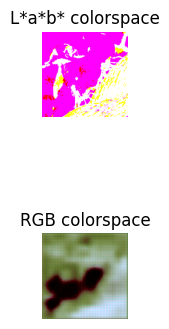

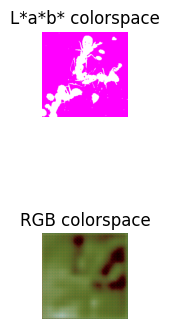

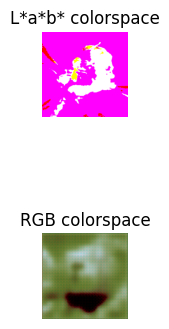

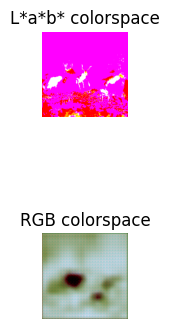

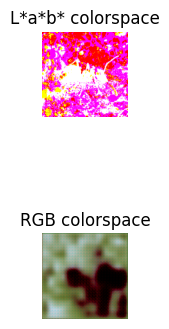

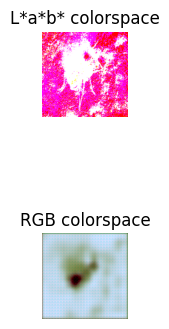

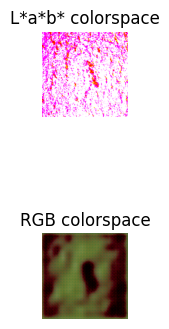

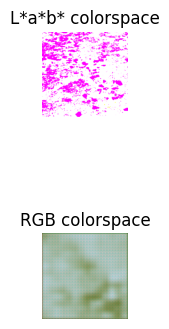

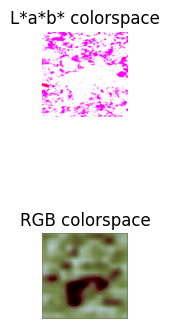

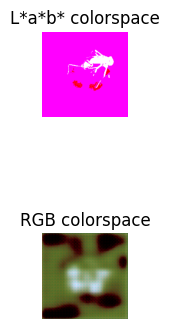

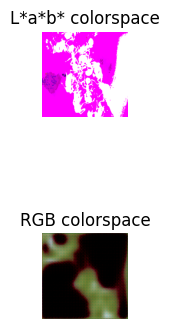

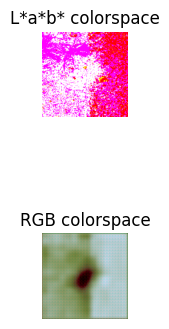

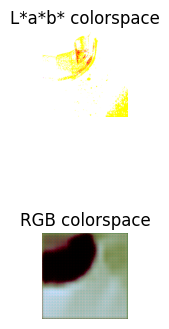

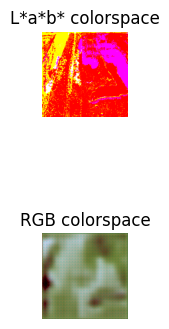

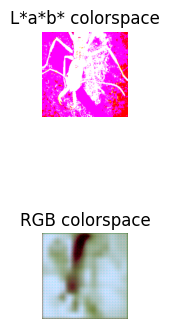

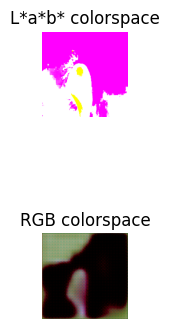

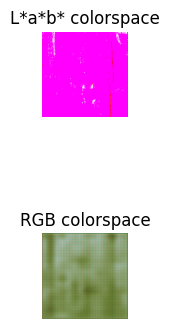

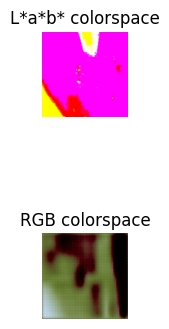

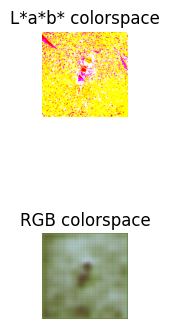

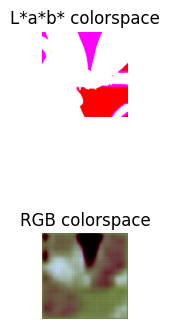

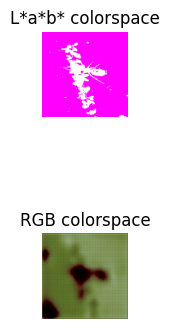

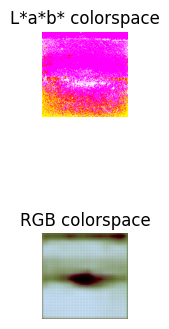

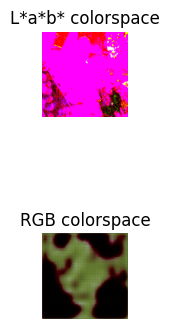

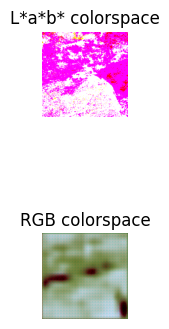

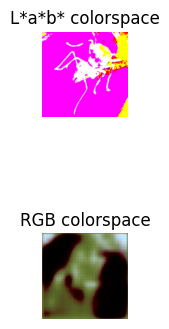

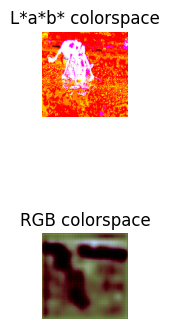

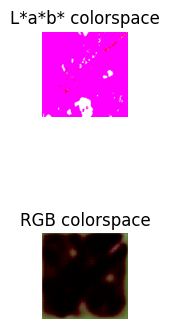

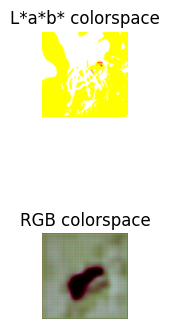

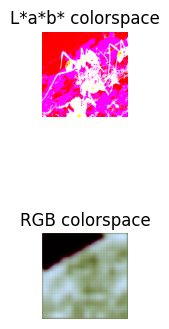

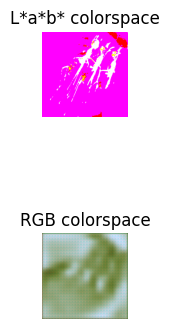

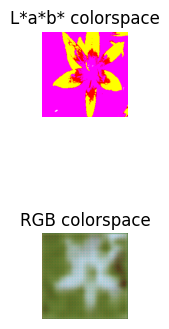

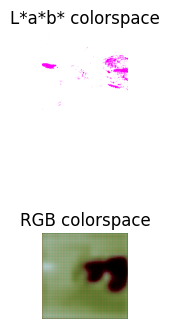

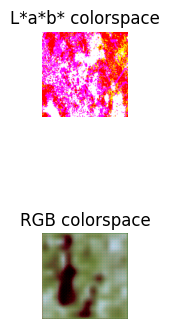

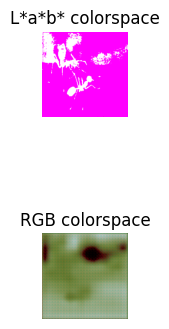

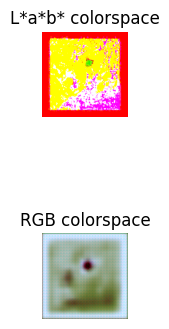

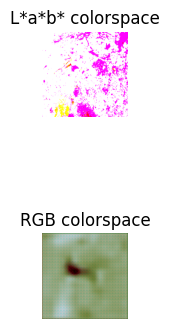

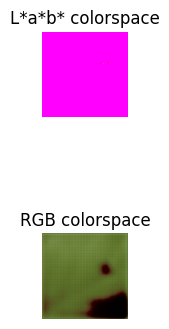

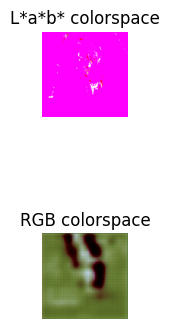

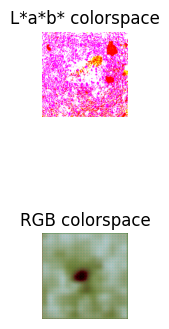

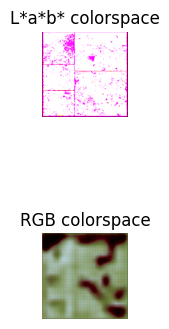

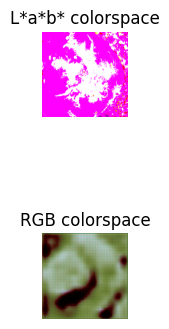

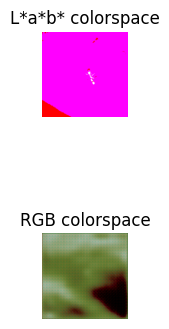

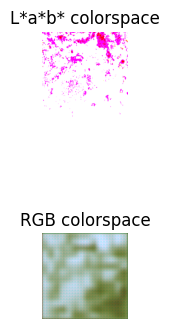

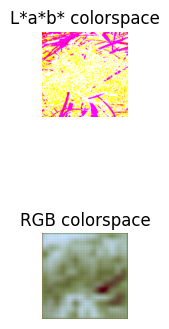

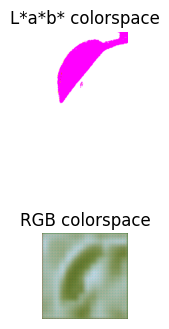

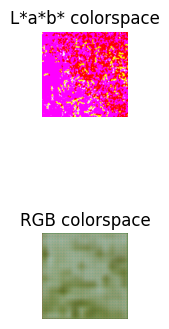

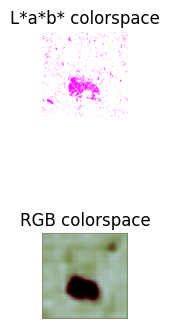

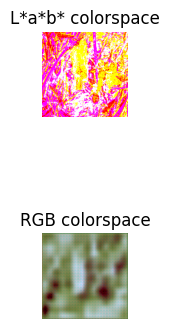

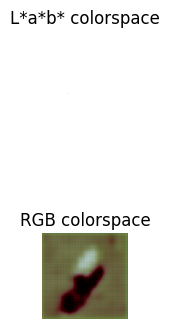

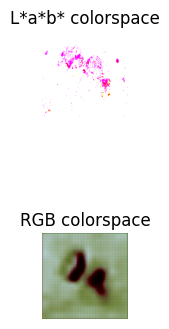

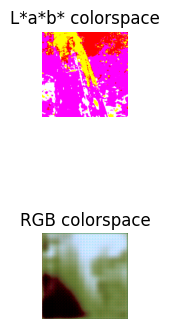

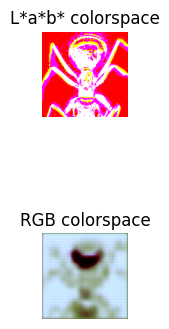

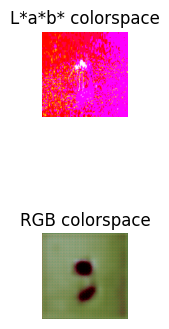

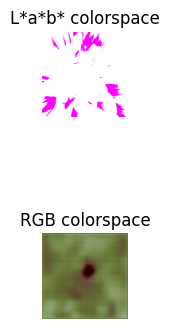

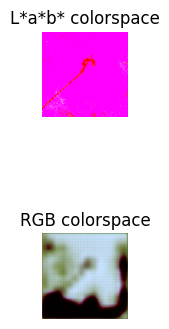

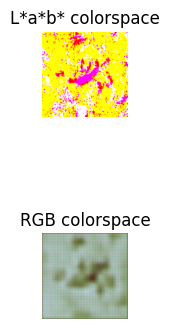

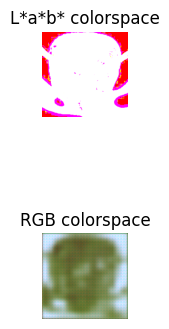

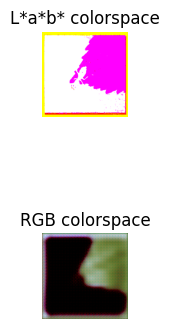

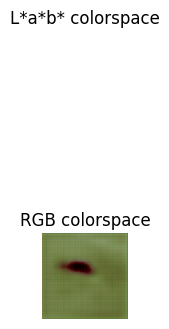

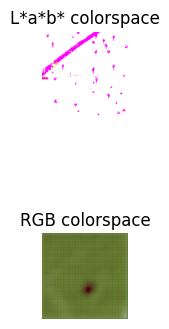

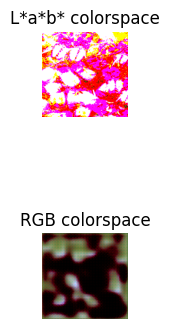

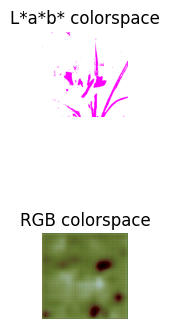

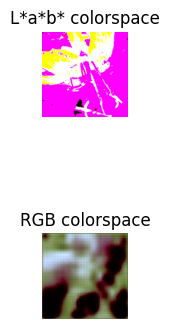

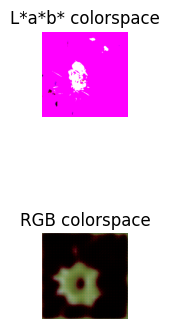

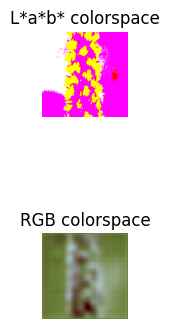

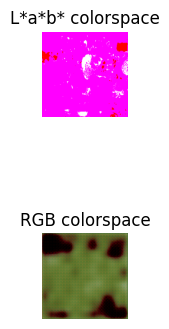

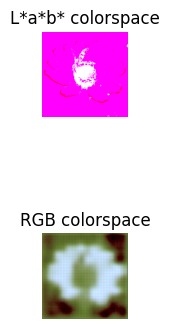

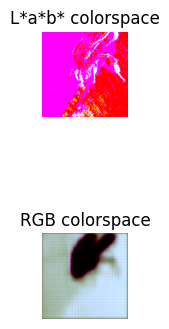

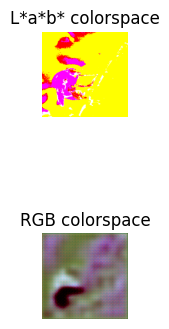

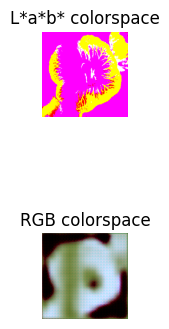

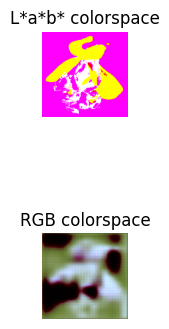

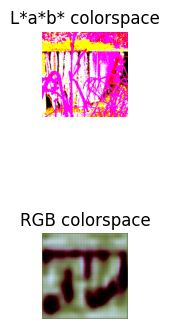

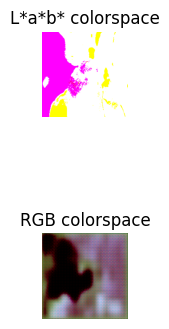

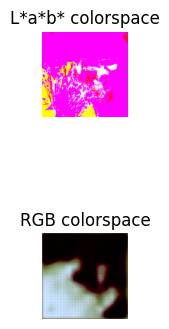

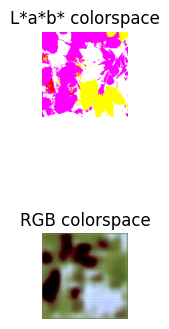

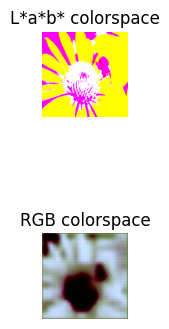

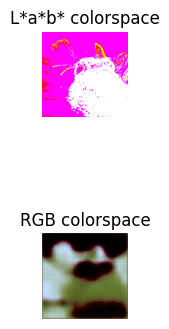

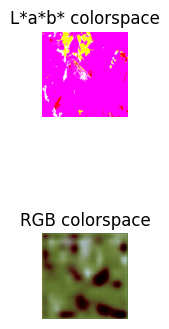

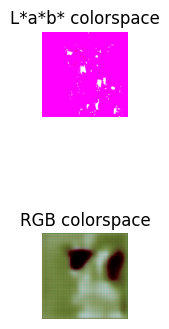

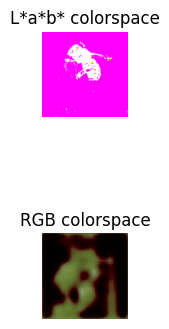

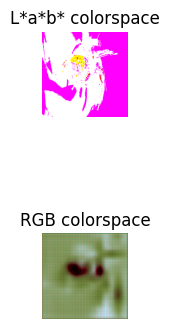

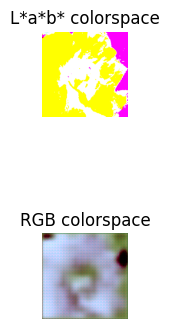

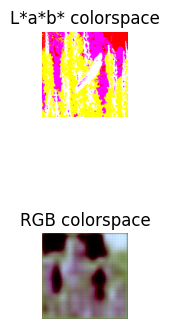

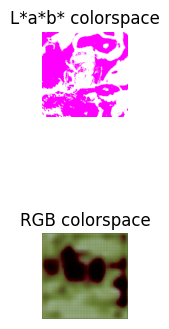

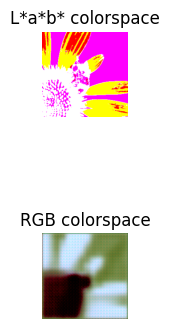

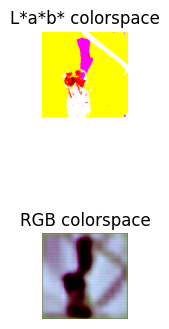

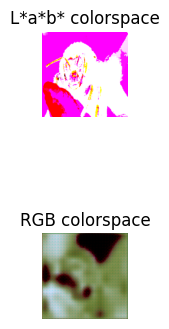

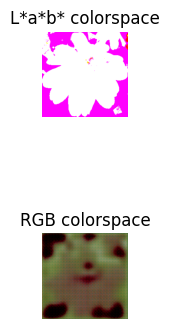

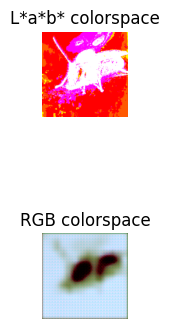

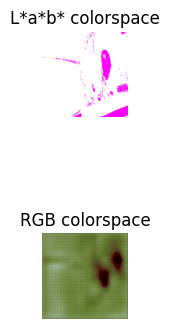

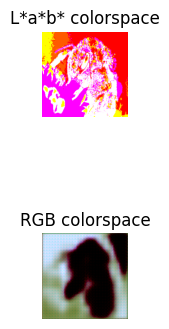

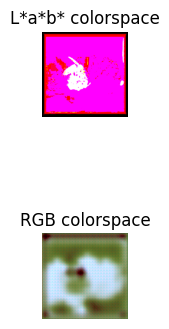

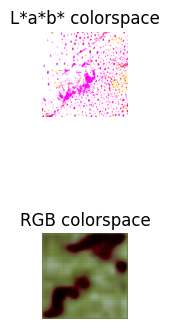

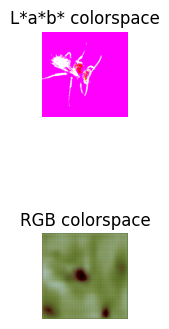

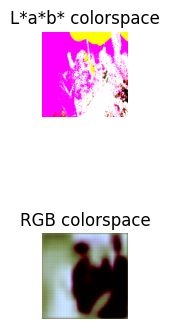

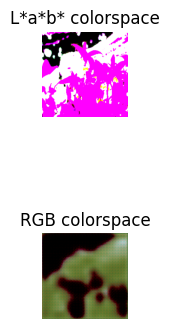

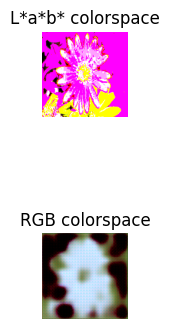

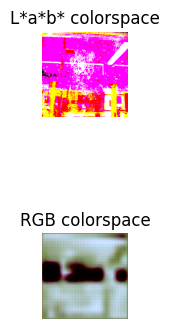

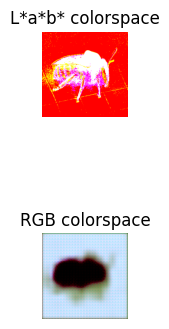

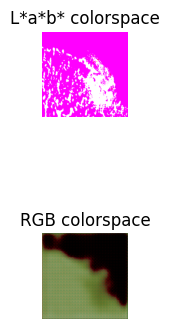

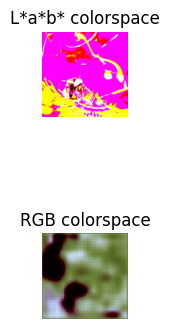

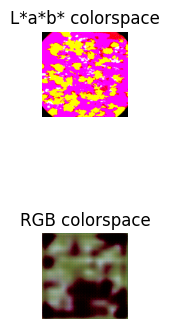

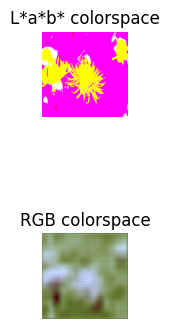

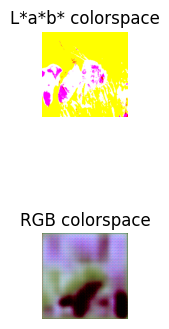

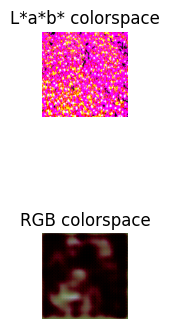

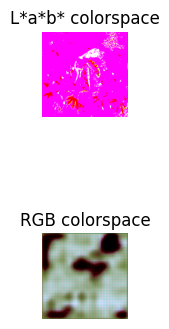

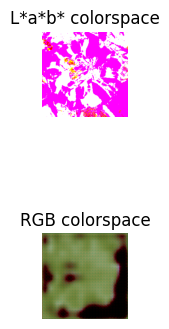

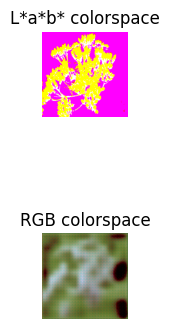

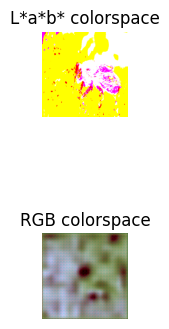

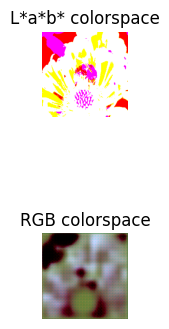

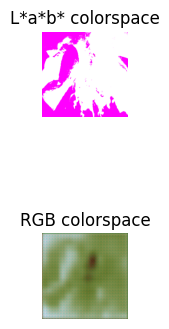

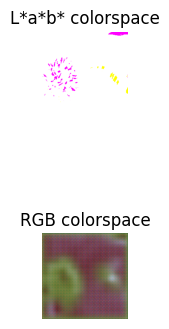

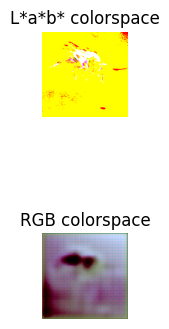

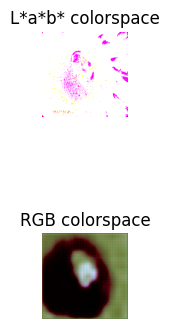

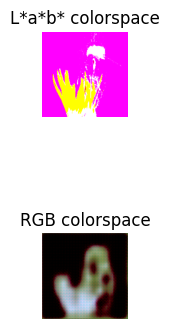

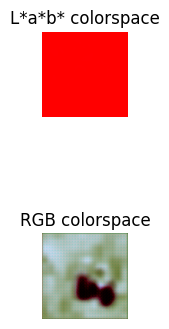

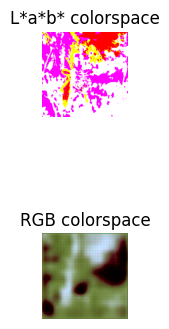

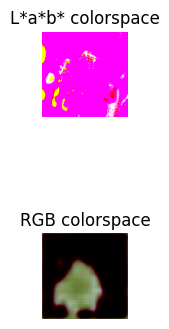

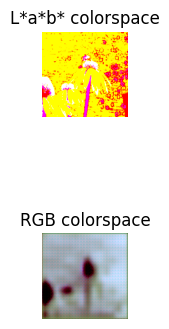

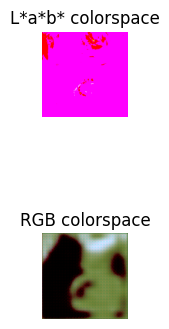

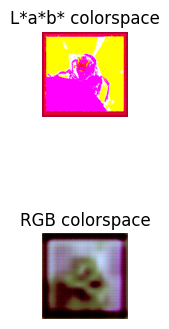

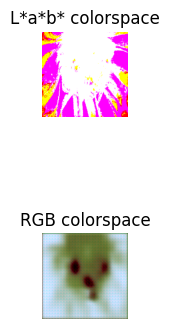

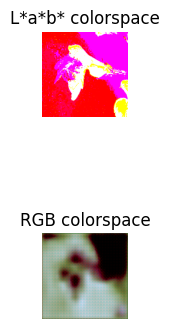

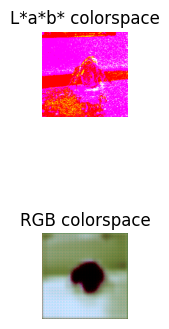

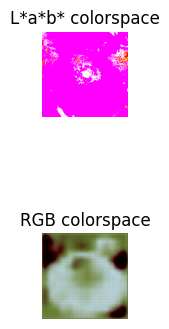

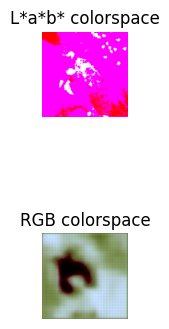

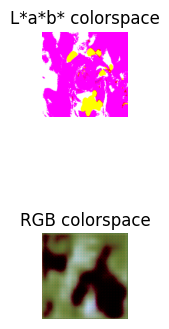

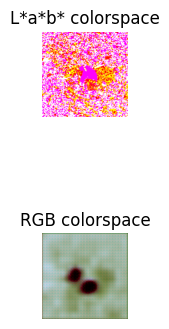

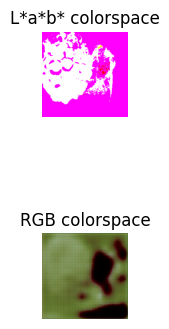

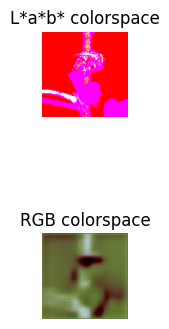

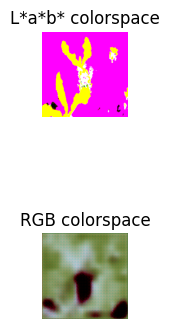

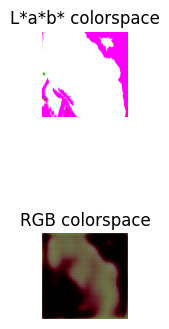

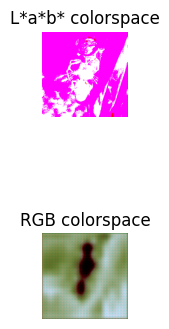

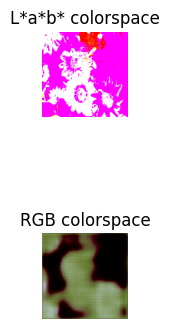

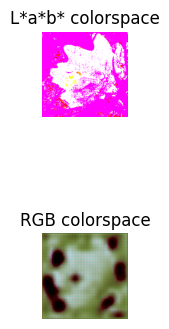

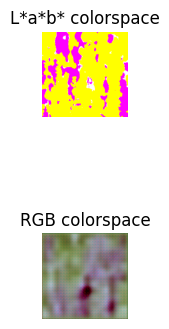

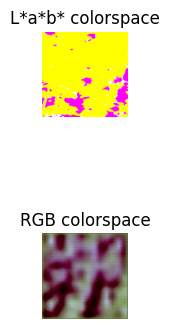

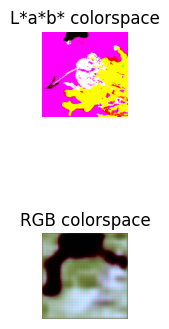

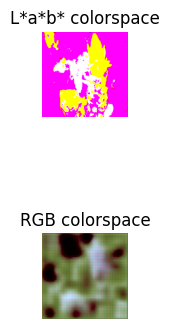

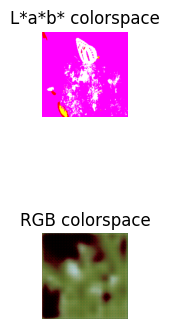

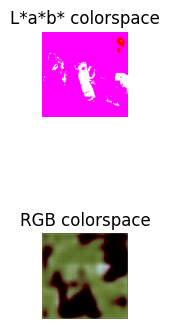

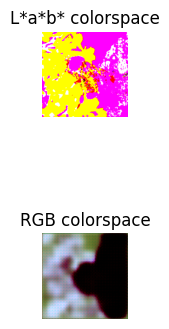

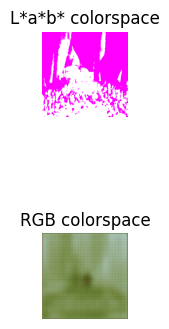

In [22]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

def evaluate_performance(model, dataloader):
    model.eval()
    mse_loss = torch.nn.MSELoss()
    mse_values = []
    rmse_values = []
    ssim_values = []
    psnr_values = []

    for data, target in dataloader:
        data, target = data.to(device), target.to(device)
        with torch.no_grad():
            recon_batch = model(data)
            mse = mse_loss(recon_batch, target)
            rmse = torch.sqrt(mse)
            mse_values.append(mse.item())
            rmse_values.append(rmse.item())

            # Convert tensors to numpy arrays and rearrange channels
            original_imgs = data.permute(0, 2, 3, 1).cpu().numpy()
            reconstructed_imgs = recon_batch.permute(0, 2, 3, 1).cpu().numpy()

            # Calculate SSIM and PSNR for each pair of images
            for original, reconstructed in zip(original_imgs, reconstructed_imgs):
                ssim_value = ssim(original, reconstructed, multichannel=True)
                psnr_value = psnr(original, reconstructed, data_range=1.0)
                ssim_values.append(ssim_value)
                psnr_values.append(psnr_value)

    avg_mse = np.mean(mse_values)
    avg_rmse = np.mean(rmse_values)
    avg_ssim = np.mean(ssim_values)
    avg_psnr = np.mean(psnr_values)

    return avg_mse, avg_rmse, avg_ssim, avg_psnr

def visualize_results(model, dataloader, num_images=5):
    model.eval()
    with torch.no_grad():
        for i, (data, _) in enumerate(dataloader):
            if i == num_images:
                break

            data = data.to(device)
            recon_batch = model(data)
            for j in range(data.size(0)):
                original_img = data[j].permute(1, 2, 0).cpu().numpy()
                reconstructed_img = recon_batch[j].permute(1, 2, 0).cpu().numpy()
                # Plot original and reconstructed images
                plt.subplot(2, num_images, i + 1)
                plt.imshow(original_img)
                plt.title("L*a*b* colorspace")
                plt.axis('off')
                plt.subplot(2, num_images, i + num_images + 1)
                plt.imshow(reconstructed_img)
                plt.title("RGB colorspace")
                plt.axis('off')
                plt.show()

# Evaluate performance
avg_mse, avg_rmse, avg_ssim, avg_psnr = evaluate_performance(model, val_dataloader)
print(f'Average MSE: {avg_mse:.4f}')
print(f'Average RMSE: {avg_rmse:.4f}')
print(f'Average SSIM: {avg_ssim:.4f}')
print(f'Average PSNR: {avg_psnr:.2f}')

# Visualize resulting images
visualize_results(model, val_dataloader)

<ipython-input-37-d01969526b28>:29: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(pca_result[:, 0], pca_result[:, 1], cmap='viridis')
<ipython-input-37-d01969526b28>:33: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(tsne_result[:, 0], tsne_result[:, 1], cmap='viridis')


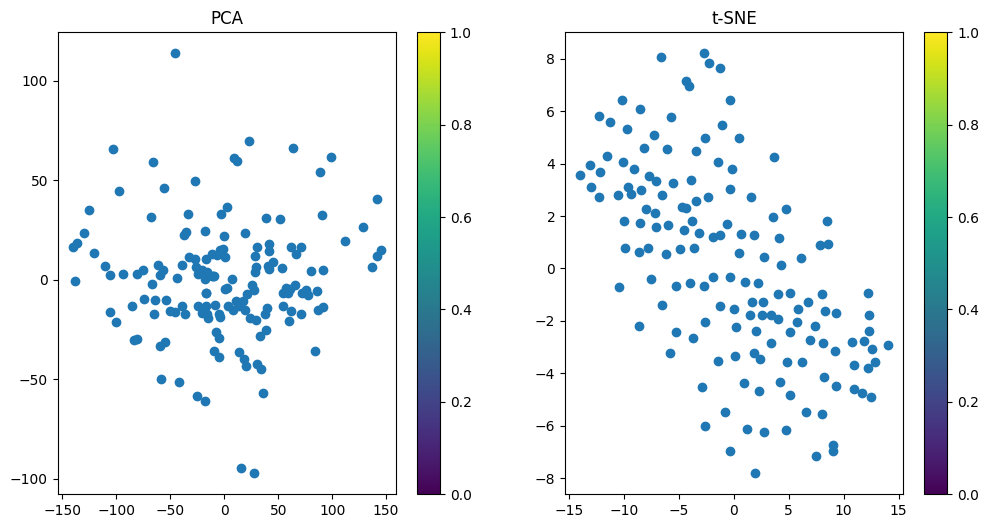

In [37]:
def visualize_features(model, dataloader):
    model.eval()
    latent_features = []
    labels = []

    with torch.no_grad():
        for data, label in dataloader:
            data, target = data.to(device), label.to(device)
            latent = model(data)
            latent_features.extend(latent.cpu())
            labels.extend(label.numpy())
    # latent_features = np.concatenate(latent_features)
    # labels = np.concatenate(labels)
    latent_features = np.array(latent_features)
    # Reshape the latent features array to have 2 dimensions
    latent_features = latent_features.reshape(len(latent_features), -1)

    # Perform PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(latent_features)

    # Perform t-SNE
    tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
    tsne_result = tsne.fit_transform(latent_features)

    # Plot PCA and t-SNE
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(pca_result[:, 0], pca_result[:, 1], cmap='viridis')
    plt.title('PCA')
    plt.colorbar()
    plt.subplot(1, 2, 2)
    plt.scatter(tsne_result[:, 0], tsne_result[:, 1], cmap='viridis')
    plt.title('t-SNE')
    plt.colorbar()
    plt.show()

# Visualize feature representations
visualize_features(model, val_dataloader)
